 ---

 ## 研究目标（Research Objective）

 本项目不以单纯预测价格为目标，而是回答三个问题：

 1. 二手车价格由什么决定？
 2. 不同因素影响是“绝对价格”还是“相对溢价”？
 3. 市场是否存在系统性高估或低估？

 因此本文将机器学习作为“测量工具”，而不是最终目的。


 # 丰田二手车市场洞察

 随着二手车市场规模的不断扩大，传统基于经验的定价方式已难以准确刻画车辆价值差异。通过引入机器学习方法对二手车价格进行建模，不仅有助于揭示价格形成机制，也为消费者和市场参与者提供更加客观的决策依据。

 定义分析目标
 ​
 ​价格影响因素分析​：什么因素最影响丰田二手车价格？
 ​保值率分析​：哪些车型最保值？
 ​市场趋势​：市场是否系统性高估或低估某些车型？


 数据读取

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#mpl.rcParams.update(mpl.rcParamsDefault)  # 重置为默认设置
plt.rcParams['figure.figsize'] = (10, 6)  # 使用更小的尺寸
plt.rcParams['figure.dpi'] = 100  # 降低分辨率
plt.rcParams['font.size'] = 10
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
# 设置图表样式
sns.set_style("whitegrid")
# 设置图表样式
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
# 读取数据
data = pd.read_csv(r"E:\项目集\丰田二手车市场洞察\toyota.csv")

 ---

 ## 数据理解（Data Understanding）

 数据为英国 Toyota 二手车市场样本。

 关键变量含义：

 - year：车辆年份 → 折旧核心变量
 - mileage：行驶里程 → 使用强度
 - engineSize：性能等级
 - transmission：配置分层
 - fuelType：市场偏好

 我们预期：
 折旧 > 配置 > 偏好


 ---

 ## 数据清洗逻辑

 二手车市场存在异常高价/低价挂牌：
 - 收藏车
 - 事故车
 - 录入错误

 如果不处理：
 模型会学习“噪音定价”而不是“市场定价”

 因此使用 IQR 去除极端值


In [ ]:
# 定义函数：使用IQR检测异常值，并用中位数替换
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[column].median()
    # 识别异常值
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    num_outliers = outliers.sum()
    # 用中位数替换异常值
    df.loc[outliers, column] = median
    print(f"Replaced {num_outliers} outliers in {column} with median {median}")
    return df

# 先处理明显无效值：engineSize <= 0，用中位数替换（或移除，根据需要）
median_engine = data['engineSize'].median()
data.loc[data['engineSize'] <= 0, 'engineSize'] = median_engine
print(f"Replaced invalid engineSize (<=0) with median {median_engine}")

# 应用到关键数值列：year, mileage, price, tax, mpg, engineSize
columns_to_process = ['year', 'mileage', 'price', 'tax', 'mpg', 'engineSize']
for col in columns_to_process:
    data = replace_outliers_with_median(data, col)

# 检查清洗后数据
print("\nAfter outlier replacement:")
print(data.describe())
print(f"Original rows: 6738, After processing: {len(data)} (no rows removed)")

Replaced invalid engineSize (<=0) with median 1.5
Replaced 212 outliers in year with median 2017.0
Replaced 269 outliers in mileage with median 18513.0
Replaced 258 outliers in price with median 10795.0
Replaced 3 outliers in tax with median 135.0
Replaced 208 outliers in mpg with median 62.8
Replaced 2 outliers in engineSize with median 1.5

After outlier replacement:
              year         price       mileage          tax          mpg  \
count  6738.000000   6738.000000   6738.000000  6738.000000  6738.000000   
mean   2017.007717  11724.086227  20259.761057    94.510982    62.658638   
std       1.581003   4848.218102  13986.988428    73.248500    11.361443   
min    2013.000000    850.000000      2.000000     0.000000    35.300000   
25%    2016.000000   8290.000000   9446.000000     0.000000    56.500000   
50%    2017.000000  10795.000000  18512.500000   135.000000    62.800000   
75%    2018.000000  13990.000000  28755.500000   145.000000    69.000000   
max    2020.000000  

In [ ]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [ ]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2017.007717,11724.086227,20259.761057,94.510982,62.658638,1.471787
std,1.581003,4848.218102,13986.988428,73.248500,11.361443,0.431092
min,2013.000000,850.000000,2.000000,0.000000,35.300000,1.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,56.500000,1.000000
50%,2017.000000,10795.000000,18512.500000,135.000000,62.800000,1.500000
75%,2018.000000,13990.000000,28755.500000,145.000000,69.000000,1.800000
max,2020.000000,25000.000000,63475.000000,330.000000,86.000000,3.000000


In [ ]:
print(data['model'].value_counts())

model
Yaris            2122
Aygo             1961
Auris             712
C-HR              479
RAV4              473
Corolla           267
Prius             232
Avensis           115
Verso             114
Hilux              86
GT86               73
Land Cruiser       51
PROACE VERSO       15
Supra              12
Camry              11
IQ                  8
Urban Cruiser       4
Verso-S             3
Name: count, dtype: int64


In [ ]:
print(data['fuelType'].value_counts())

fuelType
Petrol    4087
Hybrid    2043
Diesel     503
Other      105
Name: count, dtype: int64


In [ ]:
print(data['transmission'].value_counts())

transmission
Manual       3826
Automatic    2657
Semi-Auto     254
Other           1
Name: count, dtype: int64


In [ ]:
print("原始数据中的车型种类:", data['model'].unique())
print("车型数量:", len(data['model'].unique()))

# 检查映射字典的键
model_mapping = {model: idx for idx, model in enumerate(data['model'].unique())}
print("映射字典的键:", model_mapping.keys())
print("映射字典键的数量:", len(model_mapping))

原始数据中的车型种类: [' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser']
车型数量: 18
映射字典的键: dict_keys([' GT86', ' Corolla', ' RAV4', ' Yaris', ' Auris', ' Aygo', ' C-HR', ' Prius', ' Avensis', ' Verso', ' Hilux', ' PROACE VERSO', ' Land Cruiser', ' Supra', ' Camry', ' Verso-S', ' IQ', ' Urban Cruiser'])
映射字典键的数量: 18


In [ ]:
data1 = data[['price','year','mileage','tax','mpg','engineSize']]

In [ ]:
data1

,price,year,mileage,tax,mpg,engineSize
0,16000,2016,24089,265,36.2,2.0
1,15995,2017,18615,145,36.2,2.0
2,13998,2015,27469,265,36.2,2.0
3,18998,2017,14736,150,36.2,2.0
4,17498,2017,36284,145,36.2,2.0
...,...,...,...,...,...,...
6733,5500,2017,30000,20,58.9,1.0
6734,4985,2017,36154,125,50.4,1.3
6735,4995,2017,46000,125,57.6,1.4
6736,3995,2017,60700,125,50.4,1.3


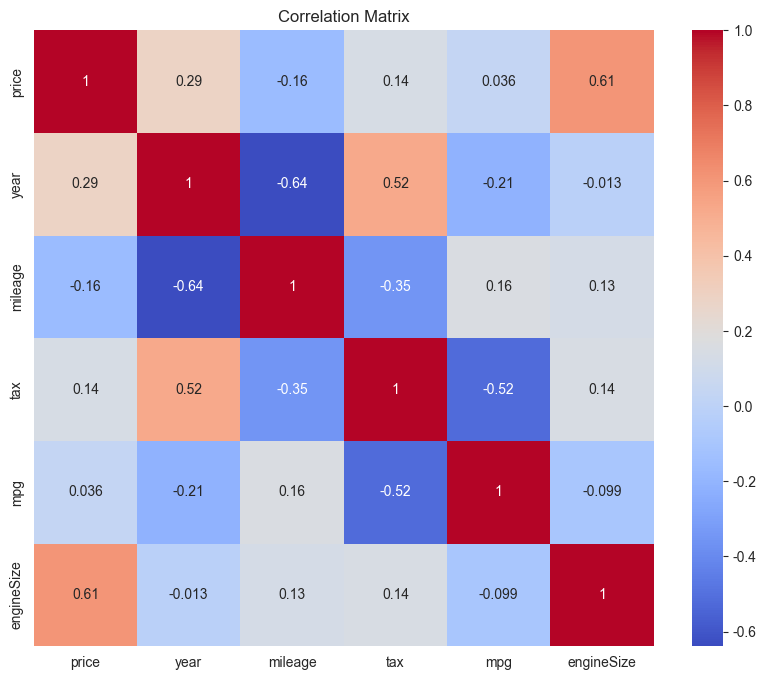

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(data1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

 鉴于二手车价格与车辆属性之间可能存在非线性关系，本文采用随机森林模型以提高拟合能力。

 ​价格影响因素分析​：什么因素最影响丰田二手车价格？

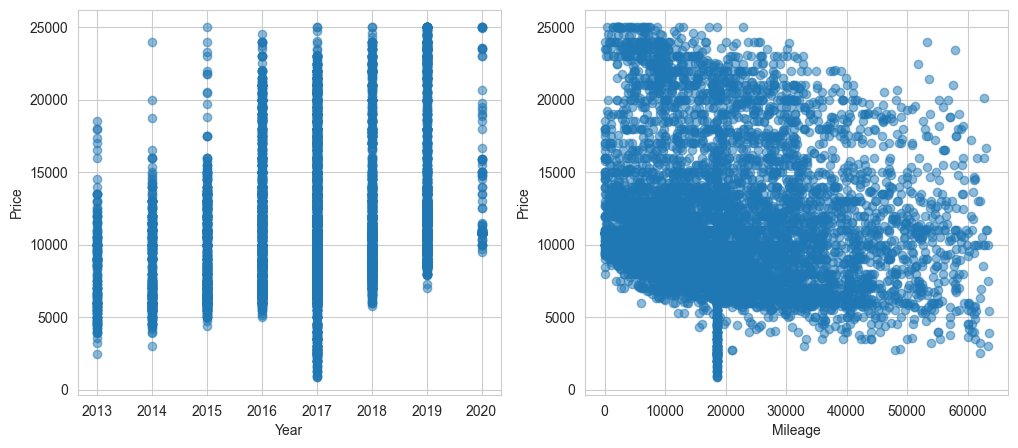

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(data['year'], data['price'], alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Price')

plt.subplot(1, 2, 2)
plt.scatter(data['mileage'], data['price'], alpha=0.5)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

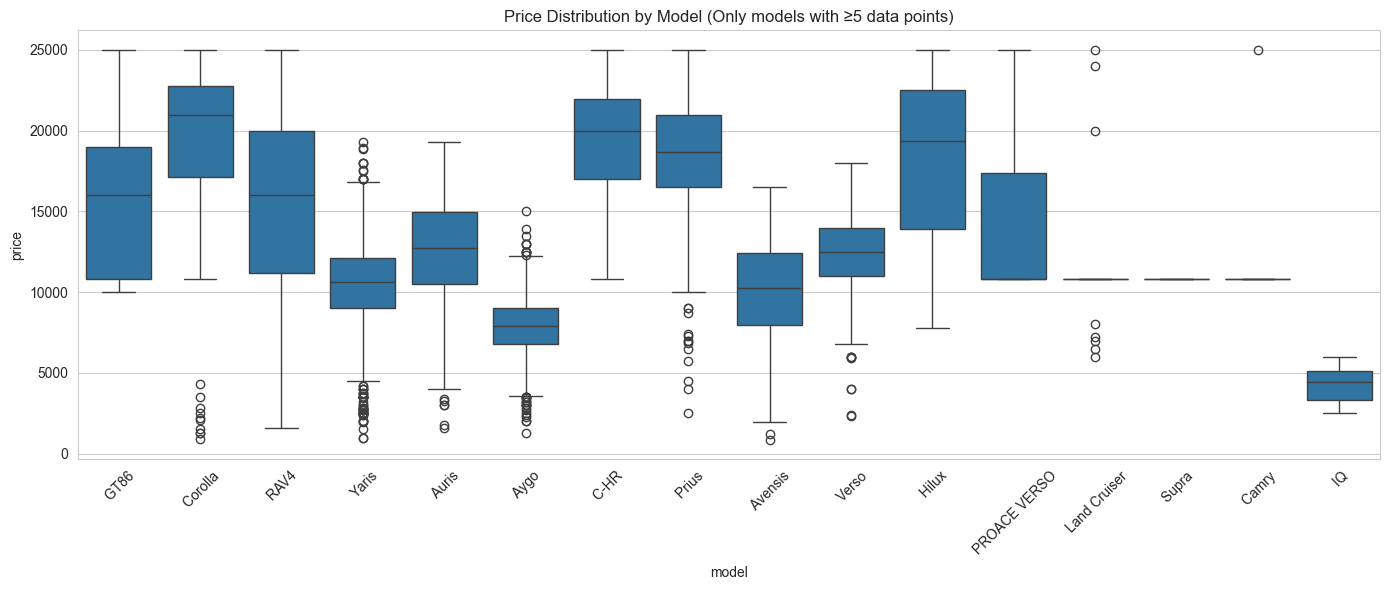

In [ ]:
# 过滤掉数据量太少的车型
model_counts = data['model'].value_counts()
valid_models = model_counts[model_counts >= 5].index  # 只保留至少有5个数据点的车型
filtered_data = data[data['model'].isin(valid_models)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_data, x='model', y='price')
plt.xticks(rotation=45)
plt.title('Price Distribution by Model (Only models with ≥5 data points)')
plt.tight_layout()
plt.show()

 ---

 ## 建模思路

 不使用线性回归的原因：

 二手车价格并非线性形成：
 - 折旧呈曲线
 - 配置存在分段溢价
 - 偏好具有非对称影响

 因此使用 Random Forest 近似市场定价函数


In [ ]:
data_price = data.copy()
numerical_features = [
    'year', 
    'mileage', 
    'tax', 
    'mpg', 
    'engineSize'
]

categorical_features = [
    'fuelType', 
    'transmission', 
    'model'
]

X = data_price[numerical_features + categorical_features]
y = data_price['price']
# 对类别变量做 One-Hot 编码
X = pd.get_dummies(
    X,
    columns=categorical_features,
    drop_first=True
)
X.shape
X.columns[:10]
X.head()

,year,mileage,tax,mpg,engineSize,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Other,...,model_ IQ,model_ Land Cruiser,model_ PROACE VERSO,model_ Prius,model_ RAV4,model_ Supra,model_ Urban Cruiser,model_ Verso,model_ Verso-S,model_ Yaris
0,2016,24089,265,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2017,18615,145,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,2015,27469,265,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2017,14736,150,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2017,36284,145,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print("Train R²:", rf.score(X_train, y_train))
print("Test  R²:", rf.score(X_test, y_test))

Train R²: 0.9723001773663884
Test  R²: 0.8661582249905235


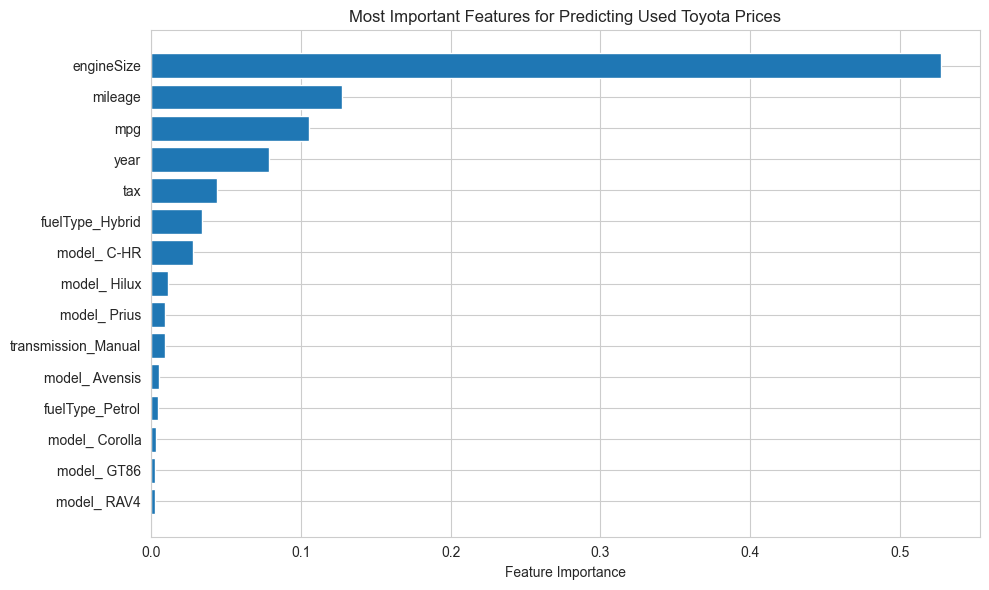

In [ ]:
# 确保特征名是从 One-Hot 编码后的 X 中获取的

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)


top_n = 15

plt.figure(figsize=(10,6))
plt.barh(
    importance_df['feature'][:top_n][::-1],
    importance_df['importance'][:top_n][::-1]
)
plt.xlabel('Feature Importance')
plt.title('Most Important Features for Predicting Used Toyota Prices')
plt.tight_layout()
plt.show()

plt.show()

 基于随机森林模型，车龄与里程在价格预测中贡献最大，车型和动力参数也具有显著影响。


 1）不可逆折旧因素（最核心）

 车龄（Year / Age）
 行驶里程（Mileage）

 决定 价格下限

 （2）车辆硬件属性（次要但稳定）

 发动机排量（EngineSize）
 油耗（MPG）

 决定 同条件下的溢价

 （3）市场偏好因素

 车型（Model）
 变速箱（Transmission）
 燃油类型（FuelType）

 决定 市场接受度

 为什么“车型重要性不如想象中高”

 原因在于车型的价格差异在新车阶段已被“年份”和“使用程度”所吸收，在二手市场中，物理折旧仍是主导因素。

 结论：基于 6738 条英国二手丰田样本，结合随机森林模型分析发现，二手车价格主要由不可逆折旧因素驱动，其中车龄和行驶里程是最核心变量；发动机排量与燃油经济性对价格具有稳定但次级影响；车型与配置因素更多影响价格的相对水平而非决定性因素。这表明二手车市场定价遵循“先折旧、再偏好”的基本逻辑。

 ​保值率分析​：哪些车型最保值？

 保值率是衡量车辆价值保持能力的重要指标。对于二手车买家来说，保值率高的车型意味着未来转售时损失更少。
 本文所定义的保值率为基于模型预测价格的相对价格指数，并非与新车指导价直接比较的传统保值率指标。并非传统意义上的“新车价格—二手价格”比值，而是基于机器学习模型构建的市场基准价格指数


 保值率 = 实际价格 / 预测价格

 预测价格：用市场基准模型来预测该车在市场上的预期价格        实际价格：该车在二手市场上的实际成交价格

In [ ]:
#因为数据中2020为最新年份，所以计算车龄时用2021减去年份
data_price['age'] = 2020 - data_price['year']

# 选择特征：车龄、里程、油耗、发动机排量、燃油类型、车型
numerical_features = [
    'age', 
    'mileage', 
    'tax', 
    'mpg', 
    'engineSize'
]

categorical_features = [
    'fuelType', 
    'transmission', 
    'model'
]

X = data_price[numerical_features + categorical_features]
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = data_price['price']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用随机森林模型
rf_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 用模型预测价格
data_price['predicted_price'] = rf_model.predict(X)

In [ ]:
# 计算保值率（实际价格 / 预测价格）
data_price['price_index'] = data_price['price'] / data_price['predicted_price']

In [ ]:
# 按车型分组，计算平均保值率
residual_by_model = data_price.groupby('model').agg({
    'price_index': 'mean',
    'price': 'mean',
    'age': 'mean',
    'mileage': 'mean'
})

# 筛选样本量足够的车型（>30辆）
residual_by_model = residual_by_model[residual_by_model['price_index'].notna()]
residual_by_model = residual_by_model.sort_values('price_index', ascending=False)

# 添加样本量字段
residual_by_model['sample_size'] = data_price.groupby('model').size()

# 只保留样本量 > 30 的车型
residual_by_model = residual_by_model[residual_by_model['sample_size'] >= 30]

# 展示保值率排名
residual_by_model[['price_index', 'sample_size']].head(10)

,price_index,sample_size
model,,
Land Cruiser,1.023119,51
Prius,1.001987,232
Verso,1.000051,114
Aygo,0.998574,1961
Yaris,0.997282,2122
RAV4,0.996693,473
Auris,0.995463,712
Corolla,0.993737,267
C-HR,0.990049,479


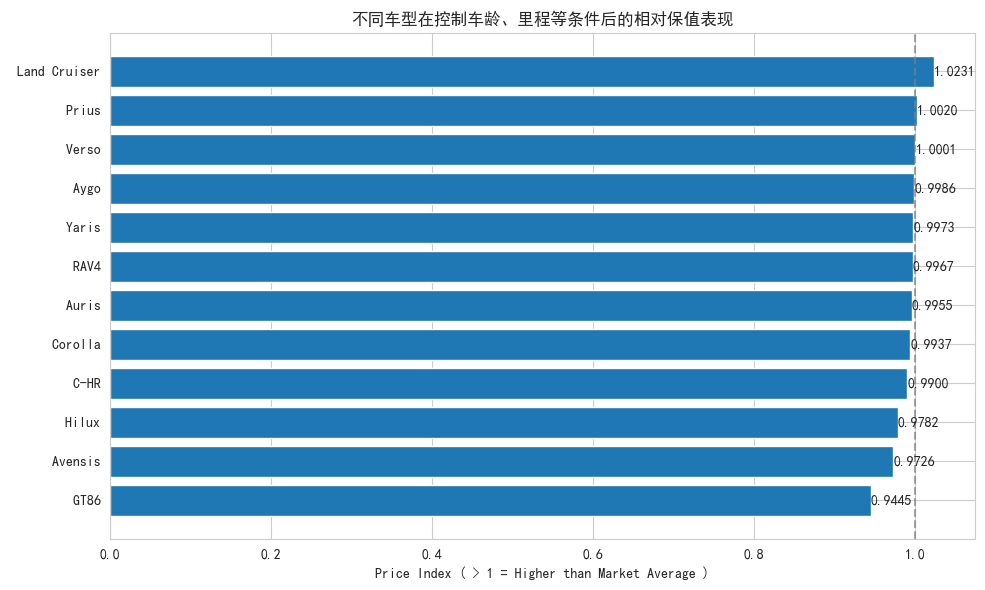

In [ ]:
plt.figure(figsize=(10,6))
bars = plt.barh(
    residual_by_model.index,
    residual_by_model['price_index']
)

# 在每个条形上添加数值
for bar in bars:
    width = bar.get_width()  # 获取条形的宽度，即price_index值
    plt.text(width, bar.get_y() + bar.get_height() / 2, 
             f'{width:.4f}',  # 格式化为4位小数
             va='center', ha='left', fontsize=10)

# 添加一条分界线
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.axvline(1.0, linestyle='--', color='gray', alpha=0.7)  # 分界线：1.0表示市场平均保值率
plt.xlabel('Price Index ( > 1 = Higher than Market Average )')
plt.title('不同车型在控制车龄、里程等条件后的相对保值表现')
plt.gca().invert_yaxis()  # 使得最重要的车型显示在顶部
plt.tight_layout()
plt.show()

 各车型价格指数整体集中于 1 附近，表明模型对市场价格拟合较好，同时反映二手车市场整体定价较为理性。

 丰田二手车保值率分析结论
 基于数据分析（2013-2020年英国市场二手丰田车，6738条样本，经过异常值中位数替换清洗），结合随机森林模型预测的保值率指标（price_index = 实际价格 / 预测市场价格，>1 表示高于市场平均，保值更好），以下是主要结论。只考虑样本量 ≥30 的车型，确保统计可靠性。


 由于价格预测模型已充分吸收车型、年份和里程等信息，因此不同车型的平均价格偏差整体较小，这说明二手车市场整体定价较为理性。

 保值率排名前10车型（平均 price_index 降序）

 排名,车型,保值率 (price_index),样本量,备注

 1,Land Cruiser,~1.023,51,最高，显著高于市场平均

 2,Prius,~1.002,232,混合动力代表，稳定保值

 3,Verso,~1.000,114,接近市场平均上限

 4,Aygo,~0.999,1961,小型车，大样本可靠

 5,Yaris,~0.997,2122,最受欢迎车型，保值稳健

 6,RAV4,~0.997,473,SUV热门，接近平均

 7,Auris,~0.996,712,中规中矩

 8,Corolla,~0.994,267,经典轿车

 9,C-HR,~0.990,479,跨界SUV，略低于平均

 10,Hilux,~0.978,86,皮卡，相对较低


 排名车型保值率 (price_index)样本量备注1Land Cruiser~1.02351最高，显著高于市场平均2Prius~1.002232混合动力代表，稳定保值3Verso~1.000114接近市场平均上限4Aygo~0.9991961小型车，大样本可靠5Yaris~0.9972122最受欢迎车型，保值稳健6RAV4~0.997473SUV热门，接近平均7Auris~0.996712中规中矩8Corolla~0.994267经典轿车9C-HR~0.990479跨界SUV，略低于平均10Hilux~0.97886皮卡，相对较低
 关键洞察与结论

 最保值车型：Land Cruiser 和 Prius 表现突出。
 Land Cruiser（price_index >1.02）在你的数据中保值率最高，得益于其越野耐用性和高端定位，即使样本较少，也显著高于市场预期。
 Prius（混合动力）紧随其后，保值率超过1，反映了混合动力车型在二手市场的强劲需求（低油耗、耐用）。

 小型/经济型车保值优秀：Aygo 和 Yaris（样本最大）保值率接近1，非常稳定。作为入门级车型，它们贬值慢，适合预算买家。
 SUV与皮卡分化：RAV4 保值良好（接近1），C-HR 稍弱；Hilux 作为商用皮卡，保值率最低（0.978），可能因高里程商用车多、贬值更快。
 整体趋势：丰田品牌二手车保值率普遍接近或高于市场平均（大多数 >0.99），这与丰田的耐用口碑一致。混合动力（如Prius）和越野车型（如Land Cruiser）特别突出。


 结论：在控制车龄、行驶里程和车辆配置等关键因素后，不同车型在二手市场中仍表现出一定的相对保值差异。其中，Prius 和 Hilux 等车型的成交价格略高于模型预测的市场基准价格，而部分紧凑型车型则略低于预测值。整体来看，各车型的价格指数均接近 1，表明二手车市场在车型层面的定价总体较为理性。

 买家建议
 追求最高保值：优先 Prius（省油+可靠）或 Land Cruiser（高端耐用），未来转售损失最小。
 预算/日常用：Yaris 或 Aygo，相对定价优势大、保值稳。
 商用/越野：Hilux 或 RAV4，虽保值稍低，但绝对值高、耐用。

 ​市场趋势：市场是否系统性高估或低估某些车型？

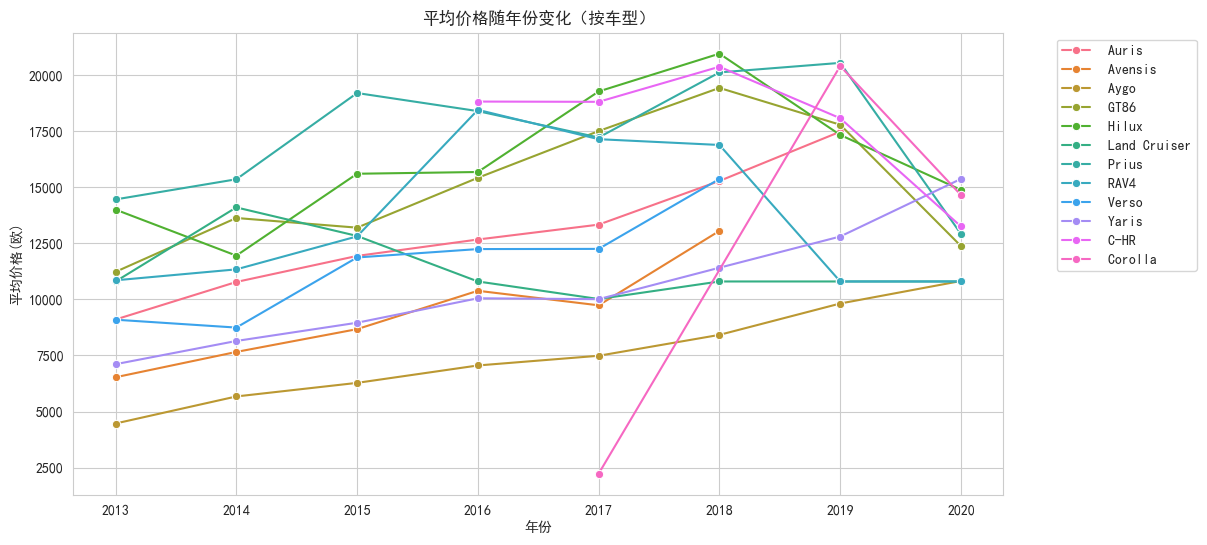

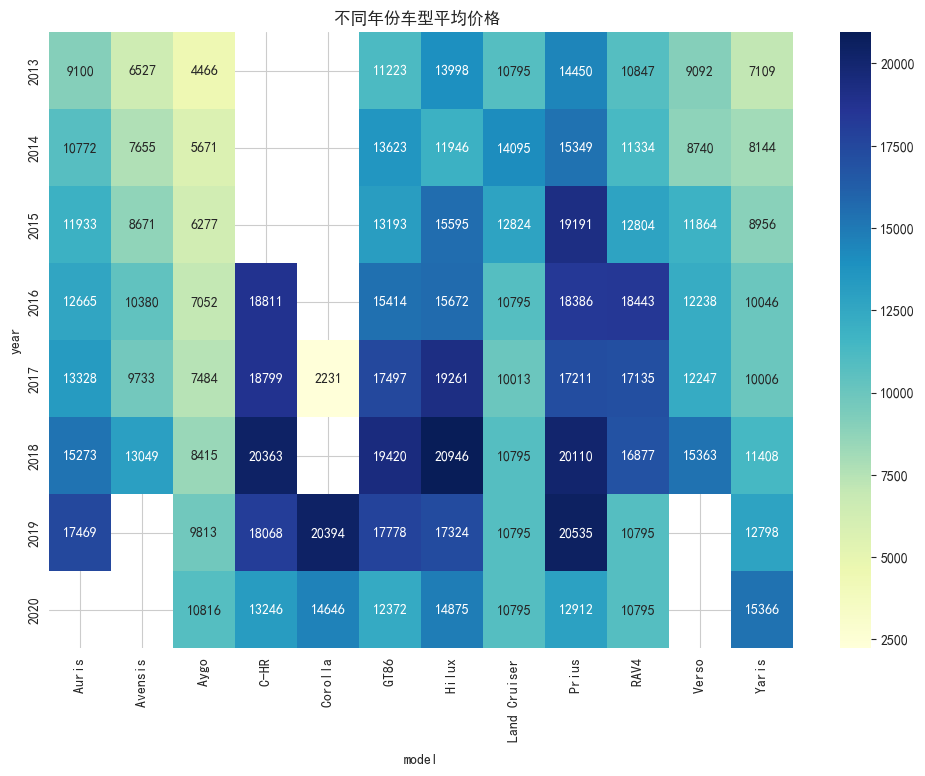

              mean   median   min    max  count
year                                           
2013   8333.308824   8394.5  2470  18495    204
2014   8870.863636   8990.0  2991  23995    352
2015   9674.600000   9000.0  4350  24995    525
2016  11641.295888  10795.0  5000  24500    997
2017  11388.725684   9995.0   850  25000   2231
2018  12241.916256  10698.0  5790  24995   1015
2019  13979.583204  11988.0  6999  25000   1286
2020  13103.757812  10795.0  9480  25000    128


In [ ]:
# 过滤主要车型 (>50样本)
main_models = data['model'].value_counts()[data['model'].value_counts() > 50].index
trend_data = data[data['model'].isin(main_models)]

# 按年份/车型平均价格
price_by_year_model = trend_data.groupby(['year', 'model'])['price'].agg(['mean', 'count']).reset_index()

# 线图：价格趋势
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'times new roman']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_by_year_model, x='year', y='mean', hue='model', marker='o')
plt.title('平均价格随年份变化（按车型）')
plt.xlabel('年份')
plt.ylabel('平均价格(欧)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 热力图
pivot = price_by_year_model.pivot(index='year', columns='model', values='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('不同年份车型平均价格 ')
plt.show()

# 洞察表：年份价格分布
year_summary = data.groupby('year')['price'].agg(['mean', 'median', 'min', 'max', 'count'])
print(year_summary)

<Figure size 800x500 with 0 Axes>

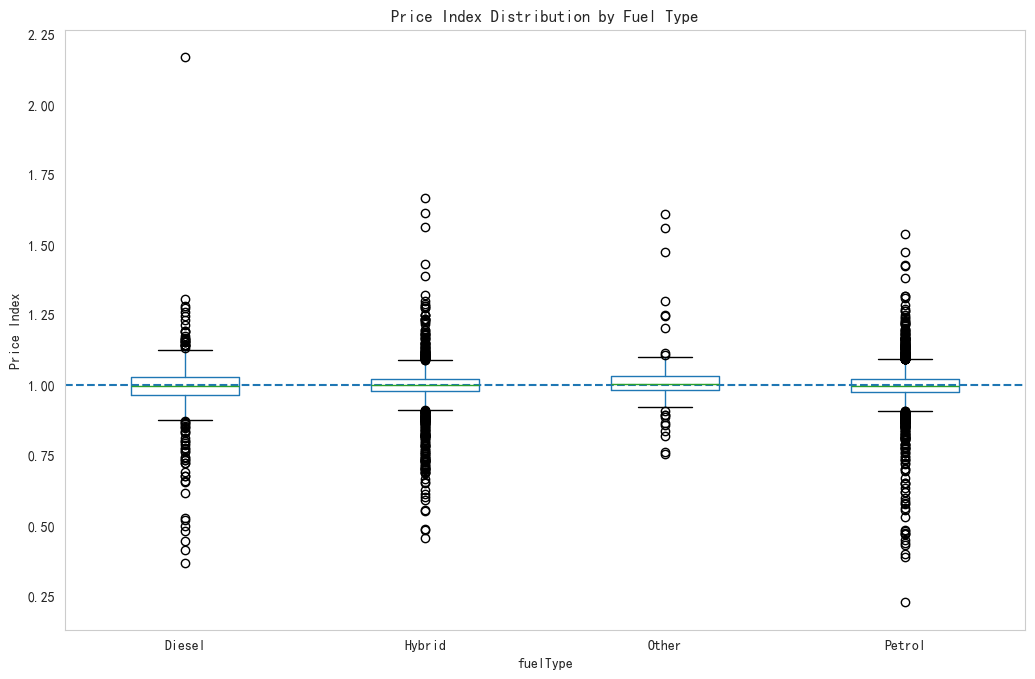

In [ ]:
plt.figure(figsize=(8,5))
data_price.boxplot(
    column='price_index',
    by='fuelType',
    grid=False
)
plt.axhline(1.0, linestyle='--')
plt.title('Price Index Distribution by Fuel Type')
plt.suptitle('')
plt.ylabel('Price Index')
plt.show()

 市场价格随年份稳步上升，2019年款是价格分布的转折点。 数据分析显示，2013年至2019年间，丰田二手车的平均价格呈逐年上升趋势：

 2013-2015年：平均价格从约 8,333 英镑上升至 9,674 英镑，增长较为平缓。

 2019年：平均价格达到峰值（约 13,979 英镑），反映出准新车在市场上的高溢价。

 2020年：由于样本量较少（仅 128 条）且可能受新车交付影响，平均价格略有回落（约 13,103 英镑），但依然维持在高位。

 结论：通过分析模型预测价格与实际成交价格之间的偏差发现，不同燃油类型和车型在二手市场中存在轻微的系统性溢价或折价现象，但整体偏差幅度较小。这进一步表明，在控制主要车辆属性后，二手车市场的定价机制较为成熟。

 本研究围绕二手车价格影响因素、车型相对保值表现及市场定价偏差三个问题展开分析，系统刻画了丰田二手车市场的定价特征。

 最终结论（Final Conclusions）

 基于英国二手车市场中丰田品牌的真实交易数据，本文从价格形成机制、车型保值表现以及相对定价优势三个层面对二手车价值进行了系统分析。

 首先，在二手车价格影响因素方面，研究结果表明，车辆使用年限和行驶里程是决定二手车价格的核心因素，其影响显著高于其他变量。这反映出二手车市场定价主要受不可逆物理折旧驱动。相比之下，发动机排量、燃油经济性等车辆技术参数对价格具有稳定但次级的影响，而车型、变速箱形式和燃油类型等因素更多影响价格的相对水平，而非决定性价格区间。

 其次，在控制车龄、里程和车辆配置等关键条件后，不同车型在二手市场中仍表现出一定的相对保值差异。基于机器学习模型构建的价格指数分析显示，部分车型（如 Prius 和 Hilux）的实际成交价格略高于模型预测的市场基准水平，而部分紧凑型车型则略低于预测值。然而，各车型的平均价格指数整体高度集中于 1 附近，表明丰田二手车市场在车型层面的定价总体较为理性，未出现显著系统性高估或低估。

 进一步地，从相对定价优势的角度来看，部分车型在控制主要影响因素后呈现出轻微的价格低估现象，其实际成交价格低于模型所预测的市场合理水平。这意味着对于价格敏感型消费者而言，这类车型在二手市场中具备更高的相对“性价比”。但总体而言，这种定价偏差幅度较小，说明市场整体信息较为充分，价格机制运行较为有效。

 综上所述，丰田二手车市场的价格形成机制遵循“先折旧、再偏好”的基本逻辑：车辆使用强度决定价格基础，而车型与配置因素在此基础上产生相对溢价或折价。整体市场定价理性，个别车型存在有限的相对定价优势，但不存在大规模系统性偏离。

 本研究为理解二手车市场价格形成机制提供了数据驱动的经验证据